<a href="https://colab.research.google.com/github/zerotodeeplearning/ztdl-masterclasses/blob/master/notebooks/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Catalit LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time Series Forecasting

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
url = "https://raw.githubusercontent.com/zerotodeeplearning/ztdl-masterclasses/master/data/"

In [ ]:
df = pd.read_csv(url + 'Ontario_energy_demand_2003-2016.csv.gz')
df.head()

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
df.index = df.index.to_period("h")

In [ ]:
df.plot(figsize=(17,5), title="Energy demand in Ontario. All values 2002-2020");

In [ ]:
df['2015-01-01':'2015-01-31'].plot(figsize=(17,5), title="Energy demand in Ontario. January 2015");

In [ ]:
split_date = pd.Timestamp('01-01-2014')

In [ ]:
train = df.loc[:split_date]
test = df.loc[split_date:]

In [ ]:
train.shape, test.shape

In [ ]:
ax = train.plot(figsize=(17,5), title='Train and Test split in time')
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train),
                            index=train.index,
                            columns=['Scaled'])
test_scaled = pd.DataFrame(scaler.transform(test),
                           index=test.index,
                           columns=['Scaled'])

In [ ]:
ax = train_scaled.plot(figsize=(17,5), title="Scaled values")
test_scaled.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.axhline(0, color='blue')
plt.axhline(1, color='cyan')
plt.axhline(-1, color='cyan');

### Lag-1 regression

Let's predict the consumption in the next hour using the consumption in the current hour

In [ ]:
window_size = 1

In [ ]:
for s in range(1, window_size + 1):
    train_scaled['shift_{}'.format(s)] = train_scaled['Scaled'].shift(s).fillna(method='bfill')
    test_scaled['shift_{}'.format(s)] = test_scaled['Scaled'].shift(s).fillna(method='bfill')

In [ ]:
train_scaled.head()

In [ ]:
X_train = train_scaled.drop('Scaled', axis=1).values
y_train = train_scaled[['Scaled']].values

X_test = test_scaled.drop('Scaled', axis=1).values
y_test = test_scaled[['Scaled']].values

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

### Fully connected predictor

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential([
  Dense(12, input_shape=(1,),
        activation='relu'),
  Dense(1)
])


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [ ]:
h = model.fit(X_train, y_train, epochs=200,
              batch_size=500, verbose=1,
              callbacks=[early_stop])

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_pred)
plt.xlim(1200,1300)

In [ ]:
plt.plot(y_test, y_pred, '.')
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()))
plt.xlabel("True")
plt.ylabel("Predicted");

In [ ]:
def evaluate(model, X_train, y_train, X_test, y_test):
  res = model.evaluate(X_train, y_train, verbose=0)
  df = pd.DataFrame(res, index=['MSE', 'MAE'], columns=['Train'])
  df['Test'] = model.evaluate(X_test, y_test, verbose=0)
  return df

evaluate(model, X_train, y_train, X_test, y_test).round(3)

### Exercise 1: Lagged features

The model above didn't work very well, let's improve it by adding more history to the training window

- Modify the `window_size` parameter to include at least a few hours
- Add columns to the `train_scaled` dataframe to include additional shifts, your table should look like:

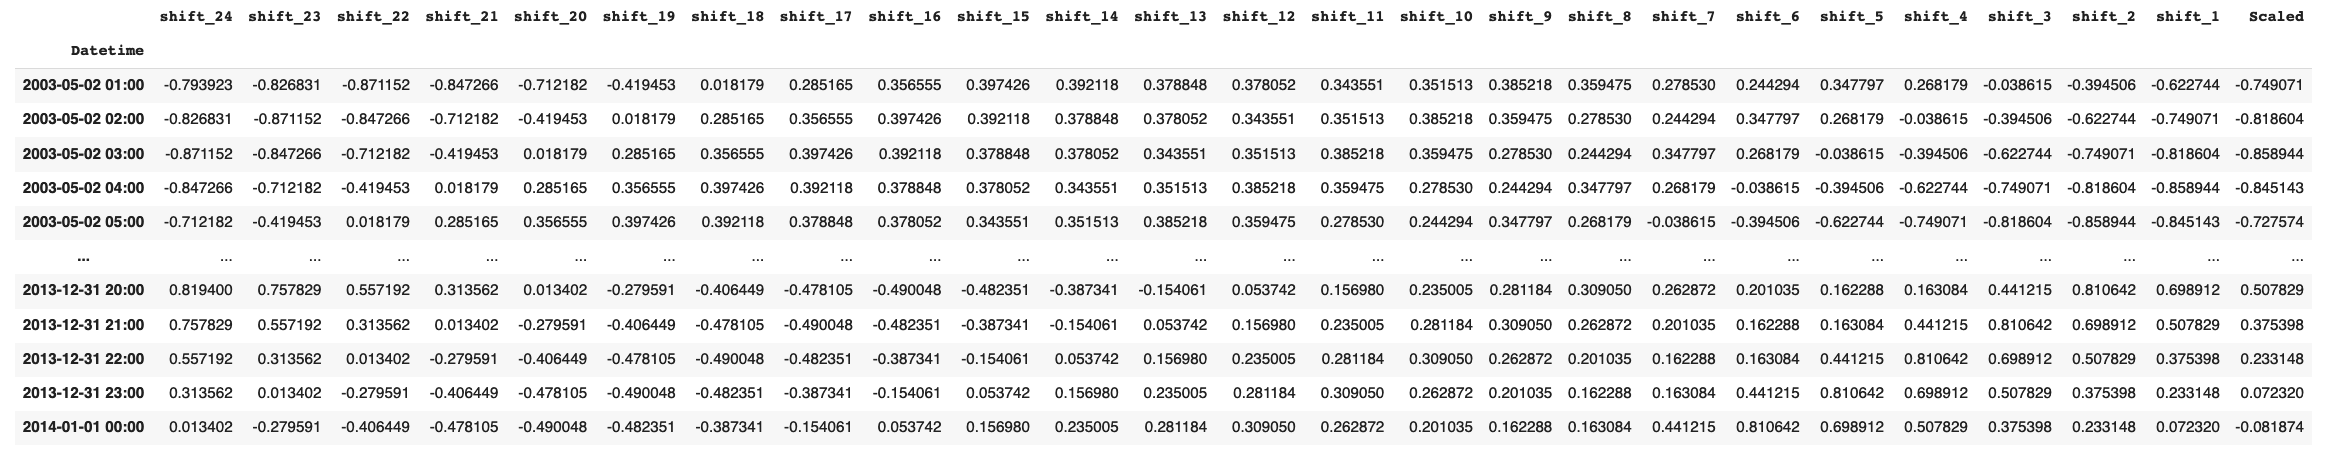

- redefine X_train, y_train, X_test, y_test from this new dataset
- train a Fully connected model with the correct input size

### Exercise 2: LSTM

Reshape the input to `(num_samples, window_size, 1)`. This means we consider each input window as a sequence of `window_size` values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- train the best recurrent model you can, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?
- plot your results
- try using GRU instead of LSTM